In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
#!gdown 1B9d9EkAHTdhRF4oWDEozKBzgoSP1dD8L

In [17]:
pd.set_option("display.max_columns", None)

In [7]:
df = pd.read_json('/Users/dan/git_repo/movs/python/2q/MLOps/ML_piplie_project/transactions.txt', lines=True)

In [6]:
del data

# EDA

In [8]:
df.shape

(786363, 29)

In [9]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [11]:
p = df.isna().sum().sum()
print(f"Total NaN in Data: {p}")

df.describe()

Total NaN in Data: 0


,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


In [12]:
df.describe(include='object')

,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363
unique,776637,2490,5,5,6,4,19,165,1820,2184,4,1,1,1,1,1,1
top,2016-12-25T14:04:15,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,PURCHASE,,,,,,
freq,4,25613,774709,778511,315035,628787,202156,5103,33623,3819,745193,786363,786363,786363,786363,786363,786363


Most of columns normalized, but not all. I'll use catboost (boosting) - it does not need to normalize the rest of the data

## Target

In [13]:
df['isFraud'][0

SyntaxError: incomplete input (539436801.py, line 1)

In [110]:
df['isFraud'] = df['isFraud'].apply(lambda x: 0 if x == 'False' else 1)

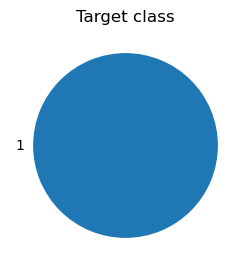

In [111]:
# Target plot
plt.figure(figsize=(3, 3))

data['isFraud'].value_counts().plot(kind="pie")
plt.title("Target class")
plt.ylabel("")
plt.xlabel("")
plt.show()

In [28]:
# Target counts
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

# Modeling

___prepaid data___

In [41]:
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostClassifier

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Class", axis=1),
    df["Class"],
    test_size=0.30,
    random_state=42,
    stratify=df["Class"],
)

In [36]:
# Split test on valid + test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

In [39]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

__model__

In [75]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [72]:
# Создаем экземпляр классификатора
params = {
    "verbose": 50,
    "random_seed": 42,
    "learning_rate": 0.008,
    "auto_class_weights": "Balanced",
    #'early_stopping_rounds' : 100,
    "eval_metric": "AUC",
    "loss_function": "Logloss",
}


cb = CatBoostClassifier(**params)

In [73]:
# Обучаем модель на данных в Pool
cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9229536	best: 0.9229536 (0)	total: 21.2ms	remaining: 21.2s
50:	test: 0.9763448	best: 0.9779247 (33)	total: 758ms	remaining: 14.1s
100:	test: 0.9775676	best: 0.9781402 (84)	total: 1.66s	remaining: 14.8s
150:	test: 0.9789713	best: 0.9789713 (150)	total: 2.64s	remaining: 14.8s
200:	test: 0.9786592	best: 0.9794124 (176)	total: 3.58s	remaining: 14.2s
250:	test: 0.9798389	best: 0.9798389 (250)	total: 4.38s	remaining: 13.1s
300:	test: 0.9799038	best: 0.9799422 (259)	total: 5.13s	remaining: 11.9s
350:	test: 0.9808421	best: 0.9808421 (350)	total: 5.97s	remaining: 11s
400:	test: 0.9804653	best: 0.9815047 (368)	total: 6.85s	remaining: 10.2s
450:	test: 0.9804251	best: 0.9815047 (368)	total: 7.69s	remaining: 9.36s
500:	test: 0.9807962	best: 0.9815047 (368)	total: 8.53s	remaining: 8.5s
550:	test: 0.9807952	best: 0.9815047 (368)	total: 9.35s	remaining: 7.62s
600:	test: 0.9797213	best: 0.9815047 (368)	total: 10.2s	remaining: 6.75s
650:	test: 0.9796237	best: 0.9815047 (368)	total: 11s	remain

In [82]:
prediction = cb.predict_proba(X_test)[:, 1]

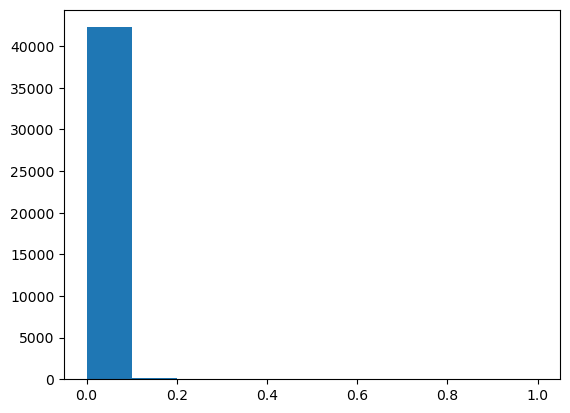

In [85]:
plt.hist(prediction)

plt.show()

In [84]:
roc_auc_score(y_test, prediction)

0.9626223719498903

In [87]:
from sklearn.metrics import confusion_matrix

In [90]:
df_test_metric = pd.DataFrame()
df_test_metric["score"] = prediction
df_test_metric["true"] = y_test.values

In [92]:
import math

In [93]:
df_test_metric["score_bin"] = df_test_metric["score"].apply(lambda x: math.floor(x * 10))

In [102]:
metrics_df = (
    df_test_metric.groupby("score_bin")["true"]
    .agg(["mean", "count", "sum"])
    .reset_index()
)
metrics_df["mean"] = round(metrics_df["mean"] * 100, 2)
metrics_df

,score_bin,mean,count,sum
0,0,0.03,42261,11
1,1,0.00,210,0
2,2,0.00,92,0
3,3,0.00,32,0
4,4,3.85,26,1
5,5,0.00,7,0
6,6,0.00,6,0
7,7,0.00,9,0
8,8,20.00,5,1
9,9,82.43,74,61
